In [1]:
import GEOparse
import pandas as pd
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt

# GSE49541

This notebook provides a brief exploration of the [GSE49541 dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE49541). Our goal is to extract (1) gene expression intensity values, (2) the condition of each patient, and (3) a symbol for each gene in the dataset.

We start by loading the dataset with GEOparse and creating a cycling iterator to go through all GEO samples.

In [2]:
gse = GEOparse.get_GEO(geo="GSE49541", destdir='../data', silent=True)
gsm_cycler = itertools.cycle(gse.gsms.items())

/home/diego/miniconda3/envs/bio/lib/python3.9/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


Here, we visualize single GEO samples, each represented by a DataFrame containing probes as rows and a `VALUE` column with the gene expression intensity values.

In [3]:
gsm_name, gsm = next(gsm_cycler)
table = gsm.table
print(table['VALUE'].describe())
table.head()

count    54675.000000
mean         3.797475
std          2.295899
min          2.358000
25%          2.358000
50%          2.426000
75%          4.642000
max         15.312000
Name: VALUE, dtype: float64


,ID_REF,VALUE
0,1007_s_at,5.043
1,1053_at,4.993
2,117_at,2.367
3,121_at,3.087
4,1255_g_at,2.358


Each GEO sample contains relevant metadata.

In [4]:
gsm_name, gsm = next(gsm_cycler)

for k, v in gsm.metadata.items():
    print(f'{k}: {v}')

title: ['NAFLD liver biopsy tissue 15006']
geo_accession: ['GSM789111']
status: ['Public on Aug 30 2013']
submission_date: ['Aug 31 2011']
last_update_date: ['Aug 30 2013']
type: ['RNA']
channel_count: ['1']
source_name_ch1: ['NAFLD liver biopsy tissue']
organism_ch1: ['Homo sapiens']
taxid_ch1: ['9606']
characteristics_ch1: ['Stage: advanced (fibrosis stage 3-4)', 'tissue: liver']
molecule_ch1: ['total RNA']
extract_protocol_ch1: ["Qiagen Micro Kit according to manufacturer's instructions"]
label_ch1: ['biotin']
label_protocol_ch1: ['Ambion MessageAmp Premier as described by the manufacturer']
hyb_protocol: ['Affymetrix GeneChip  hybridization Oven 645']
scan_protocol: ['Affymetrix GeneChip Scanner 7G']
description: ['Gene expression data from advanced NAFLD patient']
data_processing: ['GC-RMA']
platform_id: ['GPL570']
contact_name: ['Cynthia,,Moylan']
contact_email: ['cynthia.moylan@duke.edu']
contact_department: ['Gastroenterology']
contact_institute: ['Duke University Medical Cente

We are interested in knowing the condition of each patient; hence, we extract it from the `characteristics_ch1` value. The dataset contains 40 patients with mild NAFLD and 32 patients with advanced NAFLD. For integration with other datasets, we map these names to _NAFL_ and _NASH_.

In [5]:
geo_accessions = [gsm.metadata['geo_accession'][0] for _, gsm in gse.gsms.items()]
stages = [re.search(r"Stage:\s*(\w+)", gsm.metadata['characteristics_ch1'][0]).group(1) for _, gsm in gse.gsms.items()]
print('Original conditions: ', np.unique(stages))
stages = ['NAFL' if stage == 'mild' else 'NASH' for stage in stages]
values, counts = np.unique(stages, return_counts=True)

print('Conditions:')
for stage, count in zip(values, counts):
    print(f'- {stage}: {count}')

Original conditions:  ['advanced' 'mild']
Conditions:
- NAFL: 40
- NASH: 32


Now we gather all samples in a single DataFrame.

In [6]:
data = []
for i, (gsm_name, gsm) in enumerate(gse.gsms.items()):
    table = gsm.table
    table.columns = ['ID_REF', gsm_name]
    data.append(table if i == 0 else table[gsm_name])
data = pd.concat(data, axis=1)
data.set_index('ID_REF', inplace=True)

data.head()

,GSM789110,GSM789111,GSM789112,GSM789113,GSM789114,GSM789115,GSM789116,GSM789117,GSM789118,GSM789119,...,GSM789172,GSM789173,GSM789174,GSM789175,GSM789176,GSM789177,GSM789178,GSM789179,GSM789180,GSM789181
ID_REF,,,,,,,,,,,,,,,,,,,,,
1007_s_at,5.043,4.739,4.728,4.480,4.479,5.410,4.435,4.424,4.624,4.568,...,4.145,4.664,4.615,4.462,4.780,4.368,4.182,4.530,4.476,4.225
1053_at,4.993,4.996,5.056,4.987,4.707,4.987,4.728,4.905,4.987,4.987,...,5.220,4.987,4.991,4.987,4.921,4.703,4.987,5.178,4.980,4.526
117_at,2.367,2.379,2.369,2.369,2.476,2.380,2.434,2.369,2.510,2.369,...,2.367,2.427,2.373,2.365,2.369,2.369,2.369,2.369,2.383,2.366
121_at,3.087,3.087,3.069,3.087,3.087,3.087,3.087,3.087,3.087,3.076,...,3.087,3.087,3.087,3.087,3.087,3.087,3.087,3.087,3.087,3.081
1255_g_at,2.358,2.358,2.358,2.358,2.358,2.358,2.358,2.358,2.358,2.358,...,2.358,2.358,2.358,2.358,2.358,2.358,2.358,2.358,2.358,2.358


Let's plot the distribution of intensities. It seems there was some normalization done on this data. Gene expression values per sample seem to have the same scale.

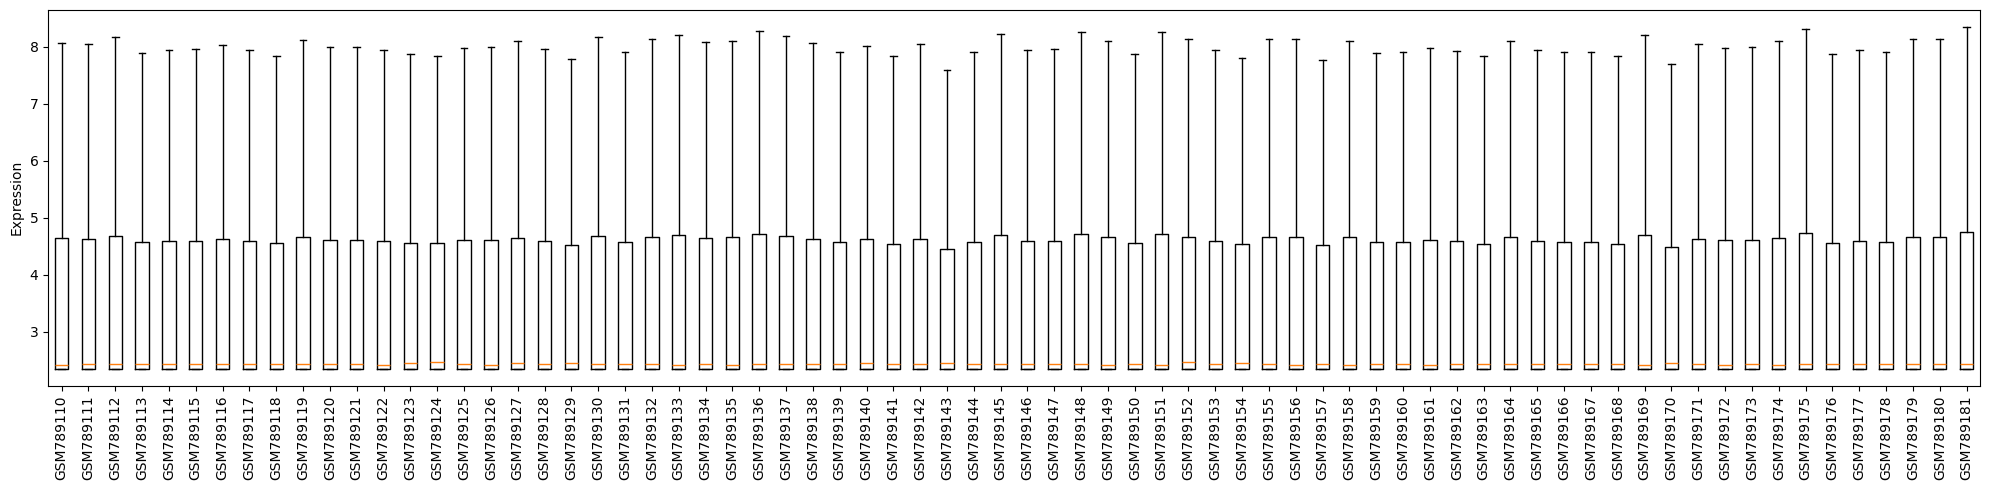

In [7]:
values = data.values.astype(float)

plt.figure(figsize=(20, 5))
plt.boxplot(values, tick_labels=data.columns, showfliers=False)
plt.xticks(rotation=90)
plt.ylabel('Expression')
plt.tight_layout()
plt.show()

Finally, we look at the platform data to search for gene symbols. Our GSE object (naturally) has one single platform.

In [8]:
gse.gpls.items()

dict_items([('GPL570', <d: GPL570>)])

The platform metadata contains relevant information, like the microarray's name, GEO accession ID, and number of probes. The table data contains information about each probe.

In [9]:
gpl = list(gse.gpls.values())[0]

print('Title: ', gpl.metadata['title'][0])
print('GEO Accession: ', gpl.metadata['geo_accession'][0])
print('Number of probes: ', gpl.metadata['data_row_count'][0])

gpl_table = gpl.table
gpl_table.head(3)

Title:  [HG-U133_Plus_2] Affymetrix Human Genome U133 Plus 2.0 Array
GEO Accession:  GPL570
Number of probes:  54675


,ID,GB_ACC,SPOT_ID,Species Scientific Name,Annotation Date,Sequence Type,Sequence Source,Target Description,Representative Public ID,Gene Title,Gene Symbol,ENTREZ_GENE_ID,RefSeq Transcript ID,Gene Ontology Biological Process,Gene Ontology Cellular Component,Gene Ontology Molecular Function
0,1007_s_at,U48705,NaN,Homo sapiens,"Oct 6, 2014",Exemplar sequence,Affymetrix Proprietary Database,U48705 /FEATURE=mRNA /DEFINITION=HSU48705 Huma...,U48705,discoidin domain receptor tyrosine kinase 1 //...,DDR1 /// MIR4640,780 /// 100616237,NM_001202521 /// NM_001202522 /// NM_001202523...,0001558 // regulation of cell growth // inferr...,0005576 // extracellular region // inferred fr...,0000166 // nucleotide binding // inferred from...
1,1053_at,M87338,NaN,Homo sapiens,"Oct 6, 2014",Exemplar sequence,GenBank,M87338 /FEATURE= /DEFINITION=HUMA1SBU Human re...,M87338,"replication factor C (activator 1) 2, 40kDa",RFC2,5982,NM_001278791 /// NM_001278792 /// NM_001278793...,0000278 // mitotic cell cycle // traceable aut...,0005634 // nucleus // inferred from electronic...,0000166 // nucleotide binding // inferred from...
2,117_at,X51757,NaN,Homo sapiens,"Oct 6, 2014",Exemplar sequence,Affymetrix Proprietary Database,X51757 /FEATURE=cds /DEFINITION=HSP70B Human h...,X51757,heat shock 70kDa protein 6 (HSP70B'),HSPA6,3310,NM_002155,0000902 // cell morphogenesis // inferred from...,0005737 // cytoplasm // inferred from direct a...,0000166 // nucleotide binding // inferred from...


Here, we are interested in gene symbols. Hence, we drop those probes with no symbol information. We retain 45,782 probes with 23,520 unique genes.

In [10]:
symbols = gpl_table['Gene Symbol'].dropna()
print(f'Number of clean probes: {len(symbols)}')
print(f'Number of unique genes: {len(symbols.unique())}')
print(f'Example genes: {symbols.sample(5).values}')

Number of clean probes: 45782
Number of unique genes: 23520
Example genes: ['FABP6' 'LOC101928001' 'KLC1' 'GPX2' 'LOC102724275']
